In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.cm as mcm


import open3d as o3d
from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# SfM Pin segmentation

In [5]:
def get_ref_color(ref_folder='./pin_ref/'):

    ref_color_folder = pathlib.Path(ref_folder)

    ref_color_rgb = []
    ref_color_hsv = {}

    for i in range(1,11):

        ref_img_path = ref_color_folder / f"{i}.png"

        ref_color_imarray = plt.imread( str(ref_img_path) )

        mask = ref_color_imarray[:,:,3] == 1

        ref_color_masked = ref_color_imarray[mask]

        ref_color_rgb.append(np.median(ref_color_masked[:,0:3], axis=0))
        ref_color_hsv[str(i)] = np.median(skimage.color.rgb2hsv(ref_color_masked[:,0:3]), axis=0)

    # custom_colormap = ListedColormap(np.asarray(ref_color_rgb))

    return ref_color_hsv

def get_hull_volume(o3d_pcd):
    pin_hull = o3d_pcd.compute_convex_hull()[0]
    hull_volume = pin_hull.get_volume() * 1000 ** 3 # mm3

    return hull_volume

def iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh):

    pin_idx = np.where(color_distance_norm < thresh)[0]

    # calculate volume, if too large needs denoise
    pin_pcd = sfm_pcd.select_by_index(pin_idx)
    hull_volume = get_hull_volume(pin_pcd) # mm3

    return hull_volume, pin_idx

def hsv_ref_pin(
    sfm_pcd_folder, potato_id, 
    ref_color_hsv, thresh=None, # for color diff
    nb_points=40, radius=0.005, # for denoise
    visualize=False
):
    # get the sfm pcd
    sfm_pcd_path = sfm_pcd_folder / f"{potato_id}_30000.ply"
    sfm_pcd = o3d.io.read_point_cloud( str(sfm_pcd_path) )

    colors = np.asarray(sfm_pcd.colors)

    colors_hsv = skimage.color.rgb2hsv(colors)

    
    # color_distance = abs(colors_hsv - ref_color_hsv[ potato_id.split('-')[-1] ]).sum(axis=1)
    color_distance_diff = abs(colors_hsv - ref_color_hsv[ potato_id.split('-')[-1] ])
    # hue -> circular distances
    need_hue_reverse = color_distance_diff[:,0] > 0.5
    color_distance_diff[need_hue_reverse, 0] = 1 - color_distance_diff[need_hue_reverse, 0]

    color_distance_weight = color_distance_diff * np.array([0.5,0.1,0.3])  # hsv weight
    color_distance = color_distance_weight.sum(axis=1)

    # 定义一个Normalize对象，用于将数据值归一化到[0, 1]的范围
    norm = mcolors.Normalize(vmin=np.min(color_distance), vmax=np.max(color_distance))

    color_distance_norm = norm(color_distance)

    # manually set the threshold
    if thresh is not None:
        hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)
    
    # looping the thresh to denoise
    else:
        thresh = 0.35
        hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)

        while hull_volume > 60:
            print(f"Thresh={thresh} get pin convex hull volumn {hull_volume} > 60, denoise first")
            pin_pcd = sfm_pcd.select_by_index(pin_idx)
            keeped, keeped_idx = pin_pcd.remove_radius_outlier(nb_points=nb_points, radius=radius)

            denoised_volume = get_hull_volume(keeped)

            if denoised_volume > 60:  # still > 50 after denoising
                thresh -= 0.05

                if thresh <0:
                    raise ValueError("Threshold can not below 0")

                hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)
            else:
                hull_volume = denoised_volume
                pin_idx = pin_idx[keeped_idx]
                print(f"Stop at thresh={thresh} with hull volume = {hull_volume} after denoising")
                break
        else:
            print(f"Stop at thresh={thresh} with hull volume = {hull_volume}")

    if visualize:
        # 选择一个colormap
        colormap = plt.cm.viridis

        # 使用colormap和Normalize对象将数据值映射到颜色
        color_array = colormap(norm(color_distance))
        sfm_pcd_cm = deepcopy(sfm_pcd)
        sfm_pcd_cm.colors = o3d.utility.Vector3dVector(color_array[:,0:3])

        # add offsets
        xyz = np.asarray(sfm_pcd_cm.points) + np.array([0.1, 0, 0])
        sfm_pcd_cm.points = o3d.utility.Vector3dVector(xyz)

        pin_pcd = sfm_pcd.select_by_index(pin_idx)
        if potato_id.split('-')[-1] == '3': # red pin
            pin_pcd.paint_uniform_color([0,1,0])
        else:
            pin_pcd.paint_uniform_color([1,0,0])
        

        o3d.visualization.draw_geometries([sfm_pcd, sfm_pcd_cm, pin_pcd], window_name=f"{potato_id} | thresh={thresh}")

    return pin_idx, sfm_pcd
        

In [3]:
sfm_pcd_folder = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin/2_SfM/2_pcd')

In [6]:
ref_color_hsv = get_ref_color('./pin_ref/')

Get the sfm pin

In [163]:
sfm_pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, 'R3-3', ref_color_hsv, visualize=True)
sfm_pin_pcd = sfm_pcd.select_by_index(sfm_pin_idx)

Thresh=0.35 get pin convex hull volumn 96018.77215018909 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 92337.85037083642 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 66611.87525249117 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 3900.371686427297 > 60, denoise first
Stop at thresh=0.2 with hull volume = 57.30333822858869 after denoising


# RGBD pin segmentation

In [8]:
from pin_regions import RgbdPinFetcher

In [9]:
rgbd_root = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin')

In [161]:
rgbd_fetcher = RgbdPinFetcher(rgbd_root)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [164]:
rgbd_pcd, rgbd_pin_pcd = rgbd_fetcher.get('R3-3', True)

# find the pin center point

convex hull -> center

In [12]:
sfm_pin_hull, sfm_pin_hull_idx = sfm_pin_pcd.compute_convex_hull()
rgbd_pin_hull, rgbd_pin_hull_idx = rgbd_pin_pcd.compute_convex_hull()

In [160]:
o3d.visualization.draw_geometries([sfm_pin_hull, sfm_pin_pcd])

In [14]:
rgbd_pin_hull_center = rgbd_pin_hull.get_center()
sfm_pin_hull_center = sfm_pin_hull.get_center()

When the pin is not correctly segmented, the center of convexhull may not the circle center.

Solution: 
1. bounding box -> find the base plane
2. project points to base plane
3. circular regression on the projected points
4. get the circle center (x,y) of on the projected plane
5. get the actual points of the circle center

### 1) get bounding box size

In [54]:
# get bounding box size
sfm_pin_hull_obb = sfm_pin_hull.get_oriented_bounding_box()

In [55]:
sfm_pin_hull_obb.scale

<bound method PyCapsule.scale of OrientedBoundingBox: center: (0.00506515, -0.0226995, 0.104844), extent: 0.00986755, 0.00808877, 0.00196617)>

In [56]:
sfm_pin_hull_obb.extent

array([0.00986755, 0.00808877, 0.00196617])

### 2) project points to base plane

In [57]:
# 获取边界框的三个轴的长度
extents = sfm_pin_hull_obb.extent

# 找到最短边和对应的索引
min_extent_idx = np.argmin(extents)
min_extent_length = extents[min_extent_idx]

# 获取对应于最短边的轴
min_extent_vector = sfm_pin_hull_obb.R[:, min_extent_idx]

min_extent_vector

array([ 0.07642455, -0.99317705,  0.08808312])

Project pin points to that plane

In [58]:
# 获取边界框的中心，作为平面上的一个点
plane_point = sfm_pin_hull_obb.center

# 初始化一个空的点云来存储投影点
projected_points = []

# 对于点云中的每个点
for point in np.asarray(sfm_pin_pcd.points):
    # 计算点到平面的向量
    point_to_plane_vec = point - plane_point
    
    # 计算点到平面的距离（投影到法向量上）
    distance = np.dot(point_to_plane_vec, min_extent_vector)
    
    # 计算投影点
    projected_point = point - distance * min_extent_vector
    
    # 添加到投影点列表中
    projected_points.append(projected_point)

# 将投影点列表转换为Open3D点云
projected_cloud = o3d.geometry.PointCloud()
projected_cloud.points = o3d.utility.Vector3dVector(projected_points)
projected_cloud = projected_cloud.paint_uniform_color([0,0,1])

In [59]:
o3d.visualization.draw_geometries([sfm_pin_pcd, projected_cloud])

---

### 3)-5) circular regression

In [101]:
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

from circle_fit import taubinSVD, hyperLSQ

In [102]:
# def project_points_to_plane(points, plane_normal, plane_point):
#     # 找到对应于最短边的轴的旋转矩阵
#     R = np.eye(3)
#     R[:, 2] = plane_normal

#     # 旋转点以对齐最短边所在的轴与z轴
#     rotated_points = np.dot(points - plane_point, R)

#     # 删除z坐标，因为所有点都在平面上
#     # points_2d = rotated_points[:, :2]
#     # points_2d = rotated_points[:, 1:]
#     points_2d = np.c_[rotated_points[:, 0], rotated_points[:, -1]]

#     return points_2d

def project_points_to_plane(points, plane_normal, plane_point):
    # 确保法向量是单位向量
    plane_normal = plane_normal / np.linalg.norm(plane_normal)

    # 计算法向量与Z轴之间的旋转
    z_axis = np.array([0, 0, 1])
    rotation_vector = np.cross(plane_normal, z_axis)
    rotation_angle = np.arccos(np.clip(np.dot(plane_normal, z_axis), -1.0, 1.0))
    
    # 如果法向量和Z轴不平行，则计算旋转矩阵
    if np.linalg.norm(rotation_vector) != 0:
        rotation_vector = rotation_vector / np.linalg.norm(rotation_vector)
        rotation_vector *= rotation_angle
        rotation = Rotation.from_rotvec(rotation_vector)
        rotation_matrix = rotation.as_matrix()
    else:
        # 如果法向量已经与Z轴平行，则不需要旋转
        rotation_matrix = np.eye(3) if np.dot(plane_normal, z_axis) > 0 else np.eye(3) * np.array([-1, -1, 1])
    
    # 将点云平移到平面点所在位置
    translated_points = points - plane_point

    # 旋转点云，使法向量与Z轴对齐
    rotated_points = np.dot(translated_points, rotation_matrix)

    # 删除Z坐标，得到二维投影
    projected_points_2d = rotated_points[:, :2]
    
    return projected_points_2d, rotation_matrix


def fit_circle_to_convex_hull(points_2d, visualize=False):
    """平面圆拟合"""

    # 获取凸包的顶点
    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]

    # xc, yc, r, sigma = taubinSVD(hull_points)
    xc, yc, r, sigma = hyperLSQ(hull_points)

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        ax.scatter(*points_2d.T, color='k', s=0.1, alpha=0.3)
        ax.scatter(*hull_points.T, color='r')
        ax.scatter([xc], [yc], color='green')
        plt.axis('equal')
        plt.show()

    return (xc, yc), r, sigma
    
# def create_circle_mesh(center, radius, normal, num_segments=100):
def create_circle_mesh(center, radius, rotation_matrix, num_segments=100):
    # 创建圆形的网格
    points = []
    indices = []
    
    # 中心点
    points.append(center)
    # 计算圆周上的点
    for i in range(num_segments):
        angle = 2 * np.pi * i / num_segments
        offset = np.array([np.cos(angle)*radius, np.sin(angle)*radius, 0])
        # 旋转以匹配法向量方向
        # R = o3d.geometry.get_rotation_matrix_from_axis_angle(normal)
        R = rotation_matrix
        rotated_offset = R.dot(offset)
        points.append(center + rotated_offset)
        if i != 0:
            # 每个三角形的索引
            indices.append([0, i, i+1])
    # 最后一个三角形的索引
    indices.append([0, num_segments, 1])
    
    # 创建三角网格
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(points)
    mesh.triangles = o3d.utility.Vector3iVector(indices)
    mesh.compute_vertex_normals()

    mesh_lineset = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    
    return mesh_lineset

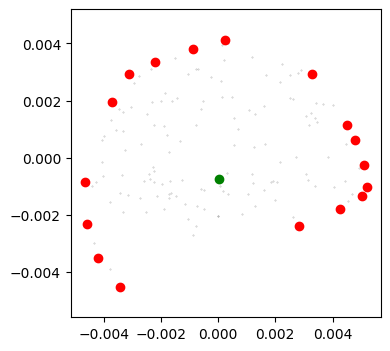

In [107]:
# get bounding box size
sfm_pin_hull_obb = sfm_pin_hull.get_oriented_bounding_box()

# 获取边界框的三个轴的长度
extents = sfm_pin_hull_obb.extent

# 找到最短边和对应的索引
min_extent_idx = np.argmin(extents)
min_extent_length = extents[min_extent_idx]

# 获取对应于最短边的轴
min_extent_vector = sfm_pin_hull_obb.R[:, min_extent_idx]

# 获取边界框的中心，作为平面上的一个点
plane_point = sfm_pin_hull_obb.center

# 投影到最短边对应的平面上
points_3d = np.asarray(sfm_pin_pcd.points)
points_2d, rotation_matrix = project_points_to_plane(points_3d, min_extent_vector, plane_point)

# 计算2D点集的凸包，并拟合圆
circle_center_2d, circle_radius, sigma = fit_circle_to_convex_hull(points_2d, visualize=True)

# 将2D圆心转换回3D空间坐标
# circle_center_3d = np.dot(np.append(circle_center_2d, 0), sfm_pin_hull_obb.R.T) + plane_point
circle_center_3d = np.dot(np.append(circle_center_2d, 0), rotation_matrix.T) + plane_point

# 初始化一个空的点云来存储投影点
projected_points = []

# 投影点云中的每个点到平面上
for point in np.asarray(sfm_pin_pcd.points):
    # 计算点到平面的向量
    point_to_plane_vec = point - plane_point
    
    # 计算点到平面的距离（投影到法向量上）
    distance = np.dot(point_to_plane_vec, min_extent_vector)
    
    # 计算投影点
    projected_point = point - distance * min_extent_vector
    
    # 添加到投影点列表中
    projected_points.append(projected_point)

# 将投影点列表转换为Open3D点云
projected_cloud = o3d.geometry.PointCloud()
projected_cloud.points = o3d.utility.Vector3dVector(projected_points)
projected_cloud = projected_cloud.paint_uniform_color([0,0,1])

# 创建一个圆形网格
# circle_mesh = create_circle_mesh(circle_center_3d, circle_radius, min_extent_vector)
circle_mesh = create_circle_mesh(circle_center_3d, circle_radius, rotation_matrix.T)

In [108]:
o3d.visualization.draw_geometries([circle_mesh, sfm_pin_hull_obb, sfm_pin_pcd, projected_cloud])

pack to function

In [119]:
def find_pin_center(pin_pcd, visualize=False):
    pin_hull, hull_idx = pin_pcd.compute_convex_hull()
    
    # get bounding box size
    hull_obb = pin_hull.get_oriented_bounding_box()

    # 获取边界框的三个轴的长度
    extents = hull_obb.extent

    # 找到最短边和对应的索引
    min_extent_idx = np.argmin(extents)
    min_extent_length = extents[min_extent_idx]

    # 获取对应于最短边的轴
    min_extent_vector = hull_obb.R[:, min_extent_idx]

    # 获取边界框的中心，作为平面上的一个点
    plane_point = hull_obb.center

    # 投影到最短边对应的平面上
    points_3d = np.asarray(pin_pcd.points)
    points_2d, rotation_matrix = project_points_to_plane(points_3d, min_extent_vector, plane_point)

    # 计算2D点集的凸包，并拟合圆
    circle_center_2d, circle_radius, sigma = fit_circle_to_convex_hull(points_2d, visualize)

    # 将2D圆心转换回3D空间坐标
    circle_center_3d = np.dot(np.append(circle_center_2d, 0), rotation_matrix.T) + plane_point

    if visualize:
        # 初始化一个空的点云来存储投影点
        projected_points = []

        # 投影点云中的每个点到平面上
        for point in np.asarray(pin_pcd.points):
            # 计算点到平面的向量
            point_to_plane_vec = point - plane_point
            
            # 计算点到平面的距离（投影到法向量上）
            distance = np.dot(point_to_plane_vec, min_extent_vector)
            
            # 计算投影点
            projected_point = point - distance * min_extent_vector
            
            # 添加到投影点列表中
            projected_points.append(projected_point)

        # 将投影点列表转换为Open3D点云
        projected_cloud = o3d.geometry.PointCloud()
        projected_cloud.points = o3d.utility.Vector3dVector(projected_points)
        projected_cloud = projected_cloud.paint_uniform_color([0,0,1])

        # 创建一个圆形网格
        circle_mesh = create_circle_mesh(circle_center_3d, circle_radius, rotation_matrix.T)

        o3d.visualization.draw_geometries([circle_mesh, pin_pcd, hull_obb, projected_cloud])

    return circle_center_3d, circle_radius, sigma

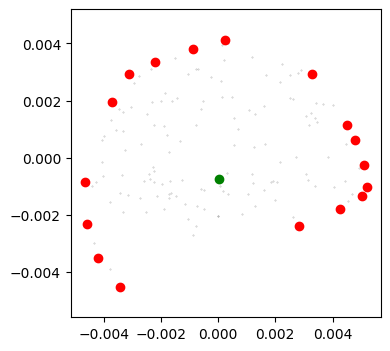

In [120]:
sfm_pin_ctr, sfm_pin_r, sfm_pin_sigma = find_pin_center(sfm_pin_pcd, visualize=True)

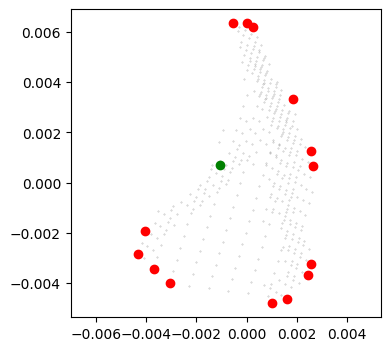

In [116]:
rgbd_pin_ctr, rgbd_pin_r, rgbd_pin_sigma = find_pin_center(rgbd_pin_pcd, visualize=True)

Test new point to plane function

In [131]:
def project_to_plane(points, plane_point, plane_normal):
    # 归一化平面法线
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    
    # 初始化三维投影点数组
    points_proj_3d = []
    
    # 初始化二维坐标点数组
    points_proj_2d = []
    
    # 计算平面的两个基向量
    if not np.allclose(plane_normal, [1, 0, 0]):
        u = np.cross(plane_normal, [1, 0, 0])
    else:
        u = np.cross(plane_normal, [0, 1, 0])
    u = u / np.linalg.norm(u)
    v = np.cross(plane_normal, u)
    
    # 对每个点进行投影
    for point in points:
        # 计算从平面点到当前点的向量
        vec = point - plane_point
        
        # 计算这个向量在平面法向量上的投影长度
        dist = np.dot(vec, plane_normal)
        
        # 计算三维空间中的投影点
        proj_point_3d = point - dist * plane_normal
        points_proj_3d.append(proj_point_3d)
        
        # 计算二维平面上的坐标
        x = np.dot(proj_point_3d - plane_point, u)
        y = np.dot(proj_point_3d - plane_point, v)
        points_proj_2d.append((x, y))
    
    return np.array(points_proj_3d), np.array(points_proj_2d), (u,v)


def project_to_plane_vectorized(points, plane_point, plane_normal):
    # 归一化平面法线
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    
    # 计算平面的两个基向量
    if not np.allclose(plane_normal, [1, 0, 0]):
        u = np.cross(plane_normal, [1, 0, 0])
    else:
        u = np.cross(plane_normal, [0, 1, 0])
    u = u / np.linalg.norm(u)
    v = np.cross(plane_normal, u)
    
    # 计算从平面点到所有点的向量
    vecs = points - plane_point
    
    # 计算这些向量在平面法向量上的投影长度
    dists = np.dot(vecs, plane_normal).reshape(-1, 1)
    
    # 计算三维空间中的投影点
    proj_points_3d = points - dists * plane_normal
    
    # 计算二维平面上的坐标
    x_coords = np.dot(proj_points_3d - plane_point, u)
    y_coords = np.dot(proj_points_3d - plane_point, v)
    
    points_proj_2d = np.column_stack((x_coords, y_coords))
    
    return proj_points_3d, points_proj_2d, (u,v)

def convert_2d_to_3d(points_2d, plane_point, u, v):
    # 将二维坐标转换为三维坐标
    points_3d = plane_point + points_2d[:, 0, np.newaxis] * u + points_2d[:, 1, np.newaxis] * v
    return points_3d

In [122]:
# 示例数据
points_3d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])  # 三维点云
plane_point = np.array([1, 2, 3])  # 平面上的一点
plane_normal = np.array([0, 0, 1])  # 平面的法线向量

In [132]:
# 执行投影
points_proj_3d, points_proj_2d, uv = project_to_plane(points_3d, plane_point, plane_normal)
print("Projected 3D Coordinates:\n", points_proj_3d)
print("Projected 2D Coordinates:\n", points_proj_2d)

Projected 3D Coordinates:
 [[1. 2. 3.]
 [4. 5. 3.]
 [7. 8. 3.]]
Projected 2D Coordinates:
 [[ 0.  0.]
 [ 3. -3.]
 [ 6. -6.]]


In [133]:
points_proj_3d, points_proj_2d, uv = project_to_plane_vectorized(points_3d, plane_point, plane_normal)
print("Projected 3D Coordinates:\n", points_proj_3d)
print("Projected 2D Coordinates:\n", points_proj_2d)

Projected 3D Coordinates:
 [[1. 2. 3.]
 [4. 5. 3.]
 [7. 8. 3.]]
Projected 2D Coordinates:
 [[ 0.  0.]
 [ 3. -3.]
 [ 6. -6.]]


In [134]:
points_back_to_3d = convert_2d_to_3d(points_proj_2d, plane_point, uv[0], uv[1])
print("2D Coordinates back to 3D:\n", points_back_to_3d)

2D Coordinates back to 3D:
 [[1. 2. 3.]
 [4. 5. 3.]
 [7. 8. 3.]]


In [155]:
def find_pin_center(pin_pcd, visualize=False):
    pin_hull, hull_idx = pin_pcd.compute_convex_hull()
    
    # get bounding box size
    hull_obb = pin_hull.get_oriented_bounding_box()

    # 获取边界框的三个轴的长度
    extents = hull_obb.extent

    # 找到最短边和对应的索引
    min_extent_idx = np.argmin(extents)
    min_extent_length = extents[min_extent_idx]

    # 获取对应于最短边的轴
    min_extent_vector = hull_obb.R[:, min_extent_idx]

    # 获取边界框的中心，作为平面上的一个点
    plane_point = hull_obb.center

    # 投影到最短边对应的平面上
    points_3d = np.asarray(pin_pcd.points)
    points_proj_3d, points_proj_2d, uv = project_to_plane_vectorized(points_3d, plane_point, min_extent_vector)

    # 计算2D点集的凸包，并拟合圆
    circle_center_2d, circle_radius, sigma = fit_circle_to_convex_hull(points_proj_2d, visualize)

    # 将2D圆心转换回3D空间坐标
    circle_center_3d = convert_2d_to_3d(np.asarray([circle_center_2d]), plane_point, uv[0], uv[1])
    circle_center_3d = circle_center_3d[0]

    if visualize:

        # 将投影点列表转换为Open3D点云
        projected_cloud = o3d.geometry.PointCloud()
        projected_cloud.points = o3d.utility.Vector3dVector(points_proj_3d)
        projected_cloud = projected_cloud.paint_uniform_color([0,0,1])

        # 创建一个圆形网格
        circle_mesh = create_circle_mesh(circle_center_2d, circle_radius, plane_point, uv)

        o3d.visualization.draw_geometries([circle_mesh, pin_pcd, hull_obb, projected_cloud])

    return circle_center_3d, circle_radius, sigma

In [156]:
def create_circle_mesh(center_2d, radius, plane_point, uv, num_segments=100):
    # 创建圆形的网格
    points = []
    indices = []
    
    # 中心点
    points.append(center_2d)
    # 计算圆周上的点
    for i in range(num_segments):
        angle = 2 * np.pi * i / num_segments
        offset = np.array([np.cos(angle)*radius, np.sin(angle)*radius])
        points.append(center_2d + offset)
        if i != 0:
            # 每个三角形的索引
            indices.append([0, i, i+1])
    # 最后一个三角形的索引
    indices.append([0, num_segments, 1])

    # 转换为3d坐标
    points = convert_2d_to_3d(np.asarray(points), plane_point, uv[0], uv[1])
    
    # 创建三角网格
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(points)
    mesh.triangles = o3d.utility.Vector3iVector(indices)
    mesh.compute_vertex_normals()

    mesh_lineset = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    
    return mesh_lineset

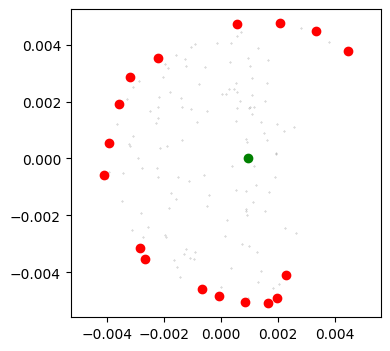

In [157]:
sfm_pin_ctr, sfm_pin_r, sfm_pin_sigma = find_pin_center(sfm_pin_pcd, visualize=True)

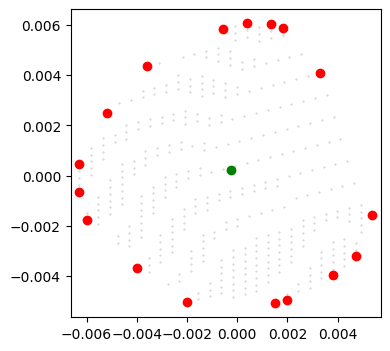

In [159]:
rgbd_pin_ctr, rgbd_pin_r, rgbd_pin_sigma = find_pin_center(rgbd_pin_pcd, visualize=True)

# ICP registration directly (failed)

Build kdtree

In [18]:
rgbd_pcd_tree = o3d.geometry.KDTreeFlann(rgbd_pcd)
sfm_pcd_tree = o3d.geometry.KDTreeFlann(sfm_pcd)

In [56]:
[rgbd_k, rgbd_nbr_idx, _] = rgbd_pcd_tree.search_radius_vector_3d(rgbd_pin_hull_center, 0.03)
[sfm_k,  sfm_nbr_idx,  _] = sfm_pcd_tree.search_radius_vector_3d(sfm_pin_hull_center, 0.03)

In [57]:
rgbd_nbr_pcd = rgbd_pcd.select_by_index(rgbd_nbr_idx)
sfm_nbr_pcd = sfm_pcd.select_by_index(sfm_nbr_idx)

In [58]:
o3d.visualization.draw_geometries([rgbd_nbr_pcd, sfm_nbr_pcd])

Some case may have back outlier?

Use colored ICP registration:

[Colored point cloud registration - Open3D primary (0cf605f) documentation](https://www.open3d.org/docs/latest/tutorial/pipelines/colored_pointcloud_registration.html)

In [26]:
# colored pointcloud registration
# This is implementation of following paper
# J. Park, Q.-Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017
voxel_radius = np.asarray([0.04, 0.02, 0.01]) / 10
max_iter = [50, 30, 14]
current_transformation = np.identity(4)
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = rgbd_nbr_pcd.voxel_down_sample(radius)
    target_down = sfm_nbr_pcd.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=iter))
    current_transformation = result_icp.transformation
    print(result_icp)
# draw_registration_result_original_color(source, target,
#                                         result_icp.transformation)



3. Colored point cloud registration
[50, 0.004, 0]
3-1. Downsample with a voxel size 0.00
3-2. Estimate normal.
3-3. Applying colored point cloud registration


RuntimeError: [1;31m[Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const open3d::geometry::PointCloud&, const open3d::geometry::PointCloud&, const CorrespondenceSet&) const) /root/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:104: No correspondences found between source and target pointcloud.
[0;m

In [38]:
current_transformation = np.identity(4)
print("2. Point-to-plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")

print("   Compute the normals")

rgbd_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
sfm_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

result_icp = o3d.pipelines.registration.registration_icp(
    rgbd_pcd, sfm_pcd, 2, current_transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(result_icp.transformation)
# draw_registration_result_original_color(source, target,
#                                         result_icp.transformation)

2. Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. Distance threshold 0.02.
   Compute the normals
[[ 0.95867697 -0.25166147  0.1326837  -0.15782891]
 [ 0.19059818  0.91438097  0.35718311 -0.133633  ]
 [-0.21121268 -0.31713395  0.9245622  -0.15130292]
 [ 0.          0.          0.          1.        ]]


In [41]:
def draw_registration_result(source, target, transformation):
    source_temp = deepcopy(source)
    target_temp = deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [42]:
draw_registration_result(rgbd_pcd, sfm_pcd, result_icp.transformation)

above full pair not working

In [51]:
current_transformation = np.identity(4)
print("2. Point-to-plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")

print("   Compute the normals")

rgbd_nbr_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
sfm_nbr_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

result_icp = o3d.pipelines.registration.registration_icp(
    rgbd_nbr_pcd, sfm_nbr_pcd, 0.4, current_transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(result_icp.transformation)
draw_registration_result(rgbd_nbr_pcd, sfm_nbr_pcd, result_icp.transformation)

2. Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. Distance threshold 0.02.
   Compute the normals
[[ 0.379157   -0.92233702  0.07439349  0.33443886]
 [ 0.05021021 -0.05977092 -0.99694853  0.52493279]
 [ 0.92396911  0.38173532  0.02364818 -0.26071623]
 [ 0.          0.          0.          1.        ]]


# Elipsoid-Fit

By openai

Reference: https://github.com/rmsandu/Ellipsoid-Fit

In [172]:
points = np.asarray(sfm_pcd.points)
points

array([[-0.0038192 , -0.01463392,  0.12344498],
       [-0.02704081,  0.00965365,  0.08738249],
       [ 0.00158402,  0.00851643,  0.06790314],
       ...,
       [-0.01005182,  0.02333051,  0.08275561],
       [-0.0261647 ,  0.00949902,  0.10779854],
       [ 0.02437466, -0.0025268 ,  0.08342717]])

In [169]:
o3d.visualization.draw_geometries([sfm_pcd])

In [166]:
# 椭球体方程的函数，需要优化的参数为椭球体的中心 (xc, yc, zc) 和轴 (a, b, c)
def ellipsoid(params, points):
    xc, yc, zc, a, b, c = params
    x, y, z = points[:,0], points[:,1], points[:,2]
    return ((x - xc)**2 / a**2 + (y - yc)**2 / b**2 + (z - zc)**2 / c**2 - 1)**2

In [170]:
# 拟合椭球体，初始参数可以是中心接近点云中心，轴长接近点云范围
initial_params = [np.mean(points[:,0]), np.mean(points[:,1]), np.mean(points[:,2]), 
                  np.ptp(points[:,0])/2, np.ptp(points[:,1])/2, np.ptp(points[:,2])/2]

# 使用 minimize 函数进行优化
result = minimize(lambda params: np.sum(ellipsoid(params, points)), initial_params, method='BFGS')

if result.success:
    fitted_params = result.x
    print(f"Fitted Ellipsoid: xc={fitted_params[0]}, yc={fitted_params[1]}, zc={fitted_params[2]}, a={fitted_params[3]}, b={fitted_params[4]}, c={fitted_params[5]}")
else:
    raise ValueError(result.message)

ValueError: Desired error not necessarily achieved due to precision loss.

In [183]:
# from https://github.com/aleksandrbazhin/ellipsoid_fit_python/tree/master
# http://www.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit
# for arbitrary axes
def ellipsoid_fit(X):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    D = np.array([x * x + y * y - 2 * z * z,
                 x * x + z * z - 2 * y * y,
                 2 * x * y,
                 2 * x * z,
                 2 * y * z,
                 2 * x,
                 2 * y,
                 2 * z,
                 1 - 0 * x])
    d2 = np.array(x * x + y * y + z * z).T # rhs for LLSQ
    u = np.linalg.solve(D.dot(D.T), D.dot(d2))
    a = np.array([u[0] + 1 * u[1] - 1])
    b = np.array([u[0] - 2 * u[1] - 1])
    c = np.array([u[1] - 2 * u[0] - 1])
    v = np.concatenate([a, b, c, u[2:]], axis=0).flatten()
    A = np.array([[v[0], v[3], v[4], v[6]],
                  [v[3], v[1], v[5], v[7]],
                  [v[4], v[5], v[2], v[8]],
                  [v[6], v[7], v[8], v[9]]])

    center = np.linalg.solve(- A[:3, :3], v[6:9])

    translation_matrix = np.eye(4)
    translation_matrix[3, :3] = center.T

    R = translation_matrix.dot(A).dot(translation_matrix.T)

    evals, evecs = np.linalg.eig(R[:3, :3] / -R[3, 3])
    evecs = evecs.T

    radii = np.sqrt(1. / np.abs(evals))
    radii *= np.sign(evals)

    a, b, c = radii
    r = (a * b * c) ** (1. / 3.)
    D = np.array([[r/a, 0., 0.], [0., r/b, 0.], [0., 0., r/c]])
    R = evecs.dot(D).dot(evecs.T)

    return center, evecs, radii, R, v

In [173]:
center, evecs, radii, v = ellipsoid_fit(points)

In [174]:
a, b, c = radii
r = (a * b * c) ** (1. / 3.)
D = np.array([[r/a, 0., 0.], [0., r/b, 0.], [0., 0., r/c]])
transformation = evecs.dot(D).dot(evecs.T)

print('')
print('center: ', center)
print('radii: ', radii)
print('evecs: ', evecs)
print('transformation:')
print(transformation)
print('Coefficients:')
print(v)


center:  [-0.00055212  0.00090132  0.09873023]
radii:  [0.02365448 0.02944703 0.03338996]
evecs:  [[ 0.42141987  0.90624412  0.0335691 ]
 [ 0.87528516 -0.39678211 -0.27647758]
 [ 0.23723656 -0.14589568  0.96043389]]
transformation:
[[1.01138114 0.08862197 0.02004152]
 [0.08862197 1.1424637  0.07968701]
 [0.02004152 0.07968701 0.87712378]]
Coefficients:
[-0.97832142 -1.30435906 -0.71731952 -0.19621868  0.03863998 -0.04315253
 -0.00417823  0.00532777  0.07088135 -0.00622346]


open3d visualize ellipsoid

In [181]:
# 已知的参数
a, b, c = 2, 1, 0.5  # 轴长abc
center = np.array([1, 2, 3])  # 中心点坐标
R = np.array([[1, 0, 0],  # 3x3旋转矩阵
              [0, 1, 0],
              [0, 0, 1]])

# 创建单位球体
mesh = o3d.geometry.TriangleMesh.create_sphere(radius=1)
mesh.compute_vertex_normals()

# 缩放变换使之变为椭球形状
# scale_matrix = np.diag([a, b, c])
# 应用非均匀缩放变换以创建椭球
scale_matrix = np.diag([a, b, c, 1])  # 构造缩放变换矩阵
mesh.scale(scale=1.0, center=mesh.get_center())  # 先将球体缩放到原点
mesh.transform(scale_matrix)  # 应用缩放变换

# 旋转变换
# rotation_transform = np.eye(4)  # 构造一个4x4的旋转变换矩阵
# rotation_transform[:3, :3] = R
mesh.rotate(R, center=(0, 0, 0))  # 假设旋转矩阵是围绕原点的

# 平移变换以移动椭球中心到给定位置
mesh.translate(center, relative=False)

mesh_frame = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)

# 可视化椭球体
o3d.visualization.draw_geometries([mesh_frame])

In [205]:
def create_o3d_ellipsoid(center, abc, R):
    """

    Parameters
    ----------
    center : np.array(np.float[3,1])
        center of ellipsoid
    abc : np.array(np.float[3,1])
        axis length
    R : np.array(np.float[3,3])
        rotation matrix of ellipsoid

    Returns
    -------
    open3d.geometry.LineSet
    """
    # 已知的参数
    a, b, c = abc  # 轴长abc

    # 创建单位球体
    mesh = o3d.geometry.TriangleMesh.create_sphere(radius=1)
    mesh.compute_vertex_normals()

    # 将球体的中心移动到原点
    mesh.translate(-mesh.get_center(), relative=True)

    # 缩放变换使之变为椭球形状
    # 应用非均匀缩放变换以创建椭球
    scale_matrix = np.diag([a, b, c, 1])  # 构造缩放变换矩阵
    mesh.scale(scale=1.0, center=mesh.get_center())  # 先将球体缩放到原点
    mesh.transform(scale_matrix)  # 应用缩放变换

    # 旋转变换
    # rotation_transform = np.eye(4)  # 构造一个4x4的旋转变换矩阵
    # rotation_transform[:3, :3] = R
    mesh.rotate(R, center=(0, 0, 0))  # 假设旋转矩阵是围绕原点的

    # 平移变换以将椭球中心移动到给定位置
    translation_transform = np.eye(4)  # 构造一个4x4的平移变换矩阵
    translation_transform[:3, 3] = center
    mesh.transform(translation_transform)  # 应用平移变换

    mesh_frame = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)

    return mesh_frame

In [206]:
center, evecs, radii, R, v = ellipsoid_fit(points)

In [211]:
sfm_elip = create_o3d_ellipsoid(center, radii, evecs)

In [212]:
o3d.visualization.draw_geometries([sfm_pcd, sfm_elip])

In [213]:
from ellipsoid_fit import ellipsoid_plot, set_axes_equal

In [199]:
%matplotlib widget

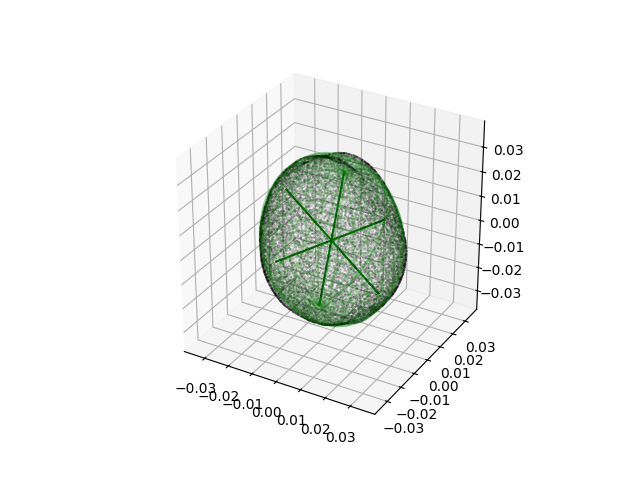

In [204]:
# data2 = data_regularize(points, divs=8)

center, evecs, radii, R, v = ellipsoid_fit(points)

data_centered = points - center.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        
ax.scatter(data_centered[:,0], data_centered[:,1], data_centered[:,2], marker='.', color='k', alpha=0.3, s=0.1)

ellipsoid_plot([0, 0, 0], radii, evecs, ax=ax, plot_axes=True, cage_color='g')

set_axes_equal(ax)
plt.show()

# Pin guided alignment

In [214]:
def find_pin_center(pin_pcd, visualize=False):
    pin_hull, hull_idx = pin_pcd.compute_convex_hull()
    
    # get bounding box size
    hull_obb = pin_hull.get_oriented_bounding_box()

    # 获取边界框的三个轴的长度
    extents = hull_obb.extent

    # 找到最短边和对应的索引
    min_extent_idx = np.argmin(extents)
    min_extent_length = extents[min_extent_idx]

    # 获取对应于最短边的轴
    min_extent_vector = hull_obb.R[:, min_extent_idx]

    # 获取边界框的中心，作为平面上的一个点
    plane_point = hull_obb.center

    # 投影到最短边对应的平面上
    points_3d = np.asarray(pin_pcd.points)
    points_proj_3d, points_proj_2d, uv = project_to_plane_vectorized(points_3d, plane_point, min_extent_vector)

    # 计算2D点集的凸包，并拟合圆
    circle_center_2d, circle_radius, sigma = fit_circle_to_convex_hull(points_proj_2d, visualize)

    # 将2D圆心转换回3D空间坐标
    circle_center_3d = convert_2d_to_3d(np.asarray([circle_center_2d]), plane_point, uv[0], uv[1])
    circle_center_3d = circle_center_3d[0]

    if visualize:

        # 将投影点列表转换为Open3D点云
        projected_cloud = o3d.geometry.PointCloud()
        projected_cloud.points = o3d.utility.Vector3dVector(points_proj_3d)
        projected_cloud = projected_cloud.paint_uniform_color([0,0,1])

        # 创建一个圆形网格
        circle_mesh = create_circle_mesh(circle_center_2d, circle_radius, plane_point, uv)

        o3d.visualization.draw_geometries([circle_mesh, pin_pcd, hull_obb, projected_cloud])

    return circle_center_3d, circle_radius, min_extent_vector, sigma

In [219]:
sfm_pin_ctr, sfm_pin_r, sfm_pin_vect, sfm_pin_sigma = find_pin_center(sfm_pin_pcd, visualize=False)
rgbd_pin_ctr, rgbd_pin_r, rgbd_pin_vect, rgbd_pin_sigma = find_pin_center(rgbd_pin_pcd, visualize=False)

In [217]:
sfm_pin_ctr, rgbd_pin_ctr

(array([ 0.00506179, -0.02261629,  0.10578551]),
 array([ 0.11385188, -0.0019237 ,  0.31832698]))

In [218]:
sfm_pin_r, rgbd_pin_r

(0.00493357359805059, 0.005759314338823653)

In [221]:
sfm_pin_vect, rgbd_pin_vect

(array([ 0.07642455, -0.99317705,  0.08808312]),
 array([-0.83435823,  0.15978767, -0.52755497]))

In [224]:
def project_points_on_vector(points, vector, return_1d=False):
    """
    把点投影到给定向量上
    输入：points: nx3的三维点
         vector: 1x3的向量
    输出：投影后的点(在空间中的位置)
    """
    v_norm = np.sqrt(sum(vector**2))

    v3d = (np.dot(points, vector.reshape(3,1))/v_norm**2)*vector

    if return_1d:
        return np.sqrt(np.sum(v3d**2, axis=1))
    else:
        return v3d

In [231]:
sfm_pcd_add_ctr = np.insert( np.asarray(sfm_pcd.points), 0, sfm_pin_ctr, axis=0)
sfm_pcd_add_ctr

array([[ 0.00506179, -0.02261629,  0.10578551],
       [-0.0038192 , -0.01463392,  0.12344498],
       [-0.02704081,  0.00965365,  0.08738249],
       ...,
       [-0.01005182,  0.02333051,  0.08275561],
       [-0.0261647 ,  0.00949902,  0.10779854],
       [ 0.02437466, -0.0025268 ,  0.08342717]])

In [232]:
sfm_on_pin_vect = project_points_on_vector(
    sfm_pcd_add_ctr, 
    sfm_pin_vect, return_1d=True)
sfm_on_pin_vect

array([0.03216674, 0.02511561, 0.00395744, ..., 0.01665016, 0.0019386 ,
       0.0117209 ])

Judge the direction of vector

In [235]:
np.where(sfm_on_pin_vect > sfm_on_pin_vect[0])[0]

array([  475,   667,   726,   769,  1602,  2039,  2111,  2287,  2471,
        2640,  2719,  2804,  3056,  3088,  3304,  3720,  3833,  3923,
        4298,  4763,  4789,  4984,  5236,  5544,  5586,  5774,  5786,
        5860,  6602,  6776,  6822,  6976,  7111,  7170,  7206,  7960,
        7994,  8001,  8040,  8071,  8107,  8176,  8333,  8612,  8697,
        8884,  9276,  9412,  9416,  9927,  9957,  9991, 10209, 10246,
       10415, 10783, 10879, 10887, 10991, 11631, 11899, 12530, 12790,
       12864, 12898, 12974, 13198, 13305, 13726, 13834, 14379, 14431,
       14496, 14562, 14698, 14963, 15058, 15089, 15185, 15374, 15385,
       15435, 15889, 16013, 16731, 16789, 16999, 17130, 18155, 18612,
       19074, 19108, 19224, 19480, 19687, 19869, 19886, 20507, 20571,
       20634, 20694, 20777, 20988, 21270, 21637, 21656, 22065, 22148,
       23164, 23512, 23606, 23949, 24135, 24153, 24231, 24360, 24558,
       24575, 24695, 24988, 25291, 25484, 25544, 25672, 25695, 25746,
       25969, 26152,

In [236]:
np.where(sfm_on_pin_vect < sfm_on_pin_vect[0])[0]

array([    1,     2,     3, ..., 29998, 29999, 30000])

In [237]:
def correct_vector_direction(points, vector, vector_root):
    # 把root插入到第一行方便对比
    root_on_top = np.insert(points, 0, vector_root, axis=0)

    root_on_top_projected = project_points_on_vector(
        points=root_on_top, 
        vector=vector, 
        return_1d=True)
    
    left_num = len(np.where(root_on_top_projected < root_on_top_projected[0])[0])
    right_num = len(np.where(root_on_top_projected > root_on_top_projected[0])[0])

    if left_num < right_num:
        return -vector
    else:
        return vector

In [238]:
sfm_pin_ctr, sfm_pin_r, sfm_pin_vect, sfm_pin_sigma = find_pin_center(sfm_pin_pcd, visualize=False)
rgbd_pin_ctr, rgbd_pin_r, rgbd_pin_vect, rgbd_pin_sigma = find_pin_center(rgbd_pin_pcd, visualize=False)

In [239]:
sfm_pin_vector = correct_vector_direction(
    np.asarray(sfm_pcd.points), sfm_pin_vect, sfm_pin_ctr
)

rgbd_pin_vector = correct_vector_direction(
    np.asarray(rgbd_pcd.points), rgbd_pin_vect, rgbd_pin_ctr
)

In [240]:
sfm_pin_vector, sfm_pin_vect

(array([ 0.07642455, -0.99317705,  0.08808312]),
 array([ 0.07642455, -0.99317705,  0.08808312]))

In [241]:
rgbd_pin_vector, rgbd_pin_vect

(array([ 0.83435823, -0.15978767,  0.52755497]),
 array([-0.83435823,  0.15978767, -0.52755497]))

Calculate transform matrix

In [242]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

    return rotation_matrix

In [244]:
rmat = rotation_matrix_from_vectors(sfm_pin_vector, rgbd_pin_vector)
rmat

array([[ 0.47381145, -0.82978398, -0.29489195],
       [ 0.80312351,  0.2697989 ,  0.53122612],
       [-0.3612414 , -0.48853568,  0.79425282]])

In [274]:
# 创建一个4x4的单位矩阵
transform_matrix = np.eye(4)

# 将3x3的旋转矩阵放入到4x4矩阵的左上角
transform_matrix[:3, :3] = rotation_matrix_from_vectors(sfm_pin_vector, rgbd_pin_vector)

# 将平移向量放入到4x4矩阵的最右列
transform_matrix[:3, 3] = sfm_pin_ctr - rgbd_pin_ctr

transform_matrix

array([[ 0.47381145, -0.82978398, -0.29489195, -0.10879008],
       [ 0.80312351,  0.2697989 ,  0.53122612, -0.02069259],
       [-0.3612414 , -0.48853568,  0.79425282, -0.21254147],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [265]:
rgbd_pdf_pin_t = deepcopy(rgbd_pcd).transform(transform_matrix)
o3d.visualization.draw_geometries([sfm_pcd, rgbd_pcd, rgbd_pdf_pin_t], window_name="source")

In [269]:
def create_transformation_matrix(P1, N1, P2, N2):
    # 将输入向量标准化
    N1 = N1 / np.linalg.norm(N1)
    N2 = N2 / np.linalg.norm(N2)
    
    # 计算旋转轴（叉积）和旋转角度（通过点积）
    cross_product = np.cross(N1, N2)
    dot_product = np.dot(N1, N2)
    if np.linalg.norm(cross_product) < 1e-5 and dot_product < 0:
        # 两个法向量指向相反方向，需要180度旋转
        # 找到与N1垂直的任意向量作为旋转轴
        axis = np.cross(N1, np.abs(N1) < 0.9).reshape(3)
        axis = axis / np.linalg.norm(axis)
        angle = np.pi
    else:
        # 一般情况下，使用叉积和点积计算旋转轴和角度
        axis = cross_product
        angle = np.arccos(dot_product)
    
    # 使用scipy来构建旋转矩阵
    rotation_matrix = Rotation.from_rotvec(axis * angle).as_matrix()
    
    # 计算平移向量
    translation = P2 - P1
    
    # 构建完整的4x4变换矩阵
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation
    
    return transformation_matrix

In [272]:
transform_matrix = create_transformation_matrix(
    sfm_pin_ctr, sfm_pin_vector,
    rgbd_pin_ctr, rgbd_pin_vector
    )

transform_matrix

array([[ 0.50674051, -0.81711428, -0.27484233,  0.10879008],
       [ 0.79212223,  0.31549514,  0.52249899,  0.02069259],
       [-0.34022996, -0.48248013,  0.80712855,  0.21254147],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [277]:
coord_xyz = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

In [278]:
rgbd_pdf_pin_t = deepcopy(rgbd_pcd).transform(transform_matrix)
o3d.visualization.draw_geometries([sfm_pcd, rgbd_pcd, rgbd_pdf_pin_t, coord_xyz], window_name="source")

In [281]:
def create_rotational_transform_matrix(P1, N1, P2, N2, rotation_point):
    # 将输入向量标准化
    N1 = N1 / np.linalg.norm(N1)
    N2 = N2 / np.linalg.norm(N2)
    
    # 计算旋转轴和旋转角度
    cross_product = np.cross(N1, N2)
    dot_product = np.dot(N1, N2)
    
    # 当两个向量平行时，叉积为零
    if np.allclose(cross_product, 0):
        # 如果点积为-1，向量相反，需要绕垂直于这些向量的轴旋转180度
        if np.isclose(dot_product, -1):
            # 选择一个与N1垂直的轴作为旋转轴
            perp_vector = np.array([1, 0, 0]) if abs(N1[0]) < abs(N1[1]) else np.array([0, 1, 0])
            rotation_axis = np.cross(N1, perp_vector)
            rotation_angle = np.pi
        else:
            # 向量重合，无需旋转
            rotation_axis = [1, 0, 0]  # 默认轴
            rotation_angle = 0
    else:
        rotation_axis = cross_product
        rotation_angle = np.arccos(dot_product)
    
    # 使用scipy来构建旋转矩阵
    rotation_matrix = Rotation.from_rotvec(rotation_axis * rotation_angle).as_matrix()
    
    # 创建平移矩阵以将旋转点移至原点
    translation_to_origin = np.eye(4)
    translation_to_origin[:3, 3] = -rotation_point
    
    # 创建平移矩阵以将旋转点移回其原始位置
    translation_back = np.eye(4)
    translation_back[:3, 3] = rotation_point
    
    # 创建旋转矩阵的4x4版本
    rot_matrix_4x4 = np.eye(4)
    rot_matrix_4x4[:3, :3] = rotation_matrix
    
    # 组合变换：平移到原点，旋转，然后平移回去
    combined_transform = translation_back @ rot_matrix_4x4 @ translation_to_origin
    
    # 计算从P1到P2的平移向量，并将其添加到变换矩阵中
    translation_vector = P2 - P1
    combined_transform[:3, 3] += translation_vector
    
    return combined_transform

In [284]:
transform_matrix =  create_rotational_transform_matrix(
    rgbd_pin_ctr, -rgbd_pin_vector,
    sfm_pin_ctr, sfm_pin_vector,
    rgbd_pin_ctr
)
transform_matrix

array([[ 0.13416383, -0.85197435, -0.50610254,  0.14925414],
       [ 0.8081049 , -0.20153607,  0.55348865, -0.29119861],
       [-0.57355605, -0.4832421 ,  0.66144579, -0.04039971],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [416]:
rgbd_pdf_pin_t = deepcopy(rgbd_pcd).transform(transform_matrix)
o3d.visualization.draw_geometries([sfm_pcd, rgbd_pcd, rgbd_pdf_pin_t, coord_xyz], window_name="source")

# Global Registration based on pin align

In [286]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [290]:
voxel_size = 0.005

In [291]:
sfm_pcd_down, sfm_pcd_fpfh = preprocess_point_cloud(sfm_pcd, voxel_size)
rgbd_pcd_down, rgbd_pcd_fpfh = preprocess_point_cloud(rgbd_pcd, voxel_size)

:: Downsample with a voxel size 0.005.
:: Estimate normal with search radius 0.010.
:: Compute FPFH feature with search radius 0.025.
:: Downsample with a voxel size 0.005.
:: Estimate normal with search radius 0.010.
:: Compute FPFH feature with search radius 0.025.


In [292]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [293]:
result_fast = execute_fast_global_registration(rgbd_pcd_down, sfm_pcd_down,
                                               rgbd_pcd_fpfh, sfm_pcd_fpfh,
                                               voxel_size=0.05)

:: Apply fast global registration with distance threshold 0.025


In [295]:
import copy

In [304]:
def draw_registration_result(source, target, transformation, paint_color=True):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if paint_color:
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [299]:
draw_registration_result(rgbd_pcd, sfm_pcd, result_fast.transformation)

Seems failed

----

In [300]:
reg_p2p = o3d.pipelines.registration.registration_icp(
    rgbd_pdf_pin_t, sfm_pcd, 0.02, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

In [301]:
reg_p2p.transformation

array([[ 0.52327891,  0.03536886,  0.85142717, -0.09185744],
       [-0.36241802,  0.91351277,  0.18479067, -0.02000405],
       [-0.77125376, -0.40526961,  0.49084028,  0.04897734],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [417]:
draw_registration_result(rgbd_pdf_pin_t, sfm_pcd, reg_p2p.transformation, paint_color=False)

### Try downsample helps or not

In [310]:
voxel_size=0.001

In [311]:
sfm_pcd_down = sfm_pcd.voxel_down_sample(voxel_size)
rgbd_pcd_down = rgbd_pdf_pin_t.voxel_down_sample(voxel_size)

In [315]:
o3d.visualization.draw_geometries([sfm_pcd_down, rgbd_pcd_down])

In [313]:
reg_p2p = o3d.pipelines.registration.registration_icp(
    rgbd_pcd_down, sfm_pcd_down, 0.02, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

In [415]:
draw_registration_result(rgbd_pdf_pin_t, sfm_pcd, reg_p2p.transformation, paint_color=False)

### Try color ICP

First step, kmeans 2 class cluster -> black and white color

In [317]:
from sklearn.cluster import KMeans

In [318]:
kmeans = KMeans(n_clusters=2)

In [319]:
kmeans.fit(np.asarray(sfm_pcd.colors))

KMeans(n_clusters=2)

In [325]:
labels

array([0, 1, 1, ..., 0, 0, 1], dtype=int32)

In [329]:
labels = kmeans.labels_

cluster_1 = sfm_pcd.select_by_index(np.where(labels == 0)[0])
cluster_2 = sfm_pcd.select_by_index(np.where(labels == 1)[0])

In [330]:
cluster_1.paint_uniform_color(np.array([1,0,0]))
cluster_2.paint_uniform_color(np.array([0,0,1]))

PointCloud with 14773 points.

In [331]:
o3d.visualization.draw_geometries([cluster_1, cluster_2])

paint uniform colors for sfm point cloud pin index

In [333]:
sfm_pin_idx

array([  222,   255,   474,   666,   725,   744,  2286,  2336,  2470,
        2639,  2718,  2894,  3055,  3087,  3303,  3611,  3719,  3832,
        3922,  4234,  4297,  4983,  5139,  5543,  5585,  5773,  5785,
        5859,  6772,  6775,  6975,  7169,  7205,  7359,  7462,  7784,
        7922,  7993,  8000,  8039,  8070,  8106,  8130,  8203,  8332,
        8373,  8611,  8696,  8877,  9415,  9926, 10414, 10782, 10878,
       10886, 11104, 11377, 11630, 12461, 12789, 12863, 12897, 12973,
       13197, 13833, 14196, 14257, 14430, 14495, 14621, 14697, 14962,
       14966, 15057, 15088, 15373, 15384, 15434, 15600, 15888, 16527,
       16788, 16998, 17165, 17491, 18062, 18098, 18154, 18374, 18611,
       19107, 19223, 19479, 19586, 19868, 19872, 19948, 19952, 20506,
       20693, 20987, 21069, 21130, 21477, 21488, 21587, 21636, 21655,
       22147, 22860, 23163, 23605, 23948, 24152, 24230, 24359, 24557,
       24987, 25053, 25290, 25543, 25694, 25745, 26018, 26151, 26535,
       26598, 27090,

In [340]:
sfm_potato_pcd = sfm_pcd.select_by_index(sfm_pin_idx, invert=True)
sfm_potato_pcd.paint_uniform_color(np.array([0,0,1]))

PointCloud with 29854 points.

In [342]:
sfm_pcd_bin = sfm_potato_pcd + sfm_pin_pcd

In [346]:
o3d.visualization.draw_geometries([sfm_pcd_bin])

In [344]:
def paint_sfm_pcd(sfm_pcd, sfm_pin_idx):
    potato_temp = sfm_pcd.select_by_index(sfm_pin_idx, invert=True)
    pin_temp = sfm_pcd.select_by_index(sfm_pin_idx, invert=False)

    potato_temp.paint_uniform_color(np.array([0,0,1]))
    pin_temp.paint_uniform_color(np.array([1,0,0]))

    return potato_temp + pin_temp

In [345]:
sfm_pcd_bin = paint_sfm_pcd(sfm_pcd, sfm_pin_idx)

paint uniform color on rgbd point cloud

In [371]:
def paint_rgbd_pcd(rgbd_pcd, rgbd_pin_pcd):
    rgbd_pcd_xyz = np.asarray(rgbd_pcd.points)
    rgbd_pin_pcd_xyz = np.asarray(rgbd_pin_pcd.points)

    rgbd_pin_idx = []

    for p in rgbd_pin_pcd_xyz:
        distance = rgbd_pcd_xyz - p

        distance = distance.sum(axis=1)

        idx_temp = np.where(distance == 0)[0]

        if idx_temp:
            rgbd_pin_idx.append(idx_temp)

    potato_temp = rgbd_pcd.select_by_index(rgbd_pin_idx, invert=True)
    pin_temp = rgbd_pcd.select_by_index(rgbd_pin_idx, invert=False)

    potato_temp.paint_uniform_color(np.array([0,0,1]))
    pin_temp.paint_uniform_color(np.array([1,0,0]))

    return potato_temp + pin_temp


In [372]:
rgbd_pcd_bin = paint_rgbd_pcd(rgbd_pcd, rgbd_pin_pcd)

/tmp/ipykernel_299765/2055270350.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  potato_temp = rgbd_pcd.select_by_index(rgbd_pin_idx, invert=True)
/tmp/ipykernel_299765/2055270350.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pin_temp = rgbd_pcd.select_by_index(rgbd_pin_idx, invert=False)


In [373]:
o3d.visualization.draw_geometries([rgbd_pcd_bin])

In [376]:
rgbd_pcd_t = deepcopy(rgbd_pcd_bin).transform(transform_matrix)

In [377]:
o3d.visualization.draw_geometries([rgbd_pcd_t])

In [382]:
sfm_pcd_down = sfm_pcd_bin.voxel_down_sample(voxel_size)
rgbd_pcd_down = rgbd_pcd_t.voxel_down_sample(voxel_size)

sfm_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
rgbd_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))

In [379]:
o3d.visualization.draw_geometries([rgbd_pcd_down, sfm_pcd_down])

In [410]:
result_icp = o3d.pipelines.registration.registration_colored_icp(
    rgbd_pcd_down, sfm_pcd_down, 0.002, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationForColoredICP(lambda_geometric=0.3), # weight of color, smaller means color more important
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000),
    )

print(result_icp.transformation)

[[ 0.26837473 -0.1088947   0.95713998 -0.10185649]
 [-0.30319514  0.93354493  0.19122386 -0.02102114]
 [-0.91435645 -0.34151984  0.21752353  0.07835135]
 [ 0.          0.          0.          1.        ]]


In [411]:
draw_registration_result(rgbd_pcd_t, sfm_pcd, result_icp.transformation, paint_color=False)

In [413]:
final_transform = result_icp.transformation @ transform_matrix

final_transform

array([[-0.60096558, -0.66923251,  0.43699911, -0.06875865],
       [ 0.60404681, -0.02223592,  0.79663857, -0.34584665],
       [-0.52341935,  0.74272028,  0.41761079,  0.03254208],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [414]:
draw_registration_result(rgbd_pcd, sfm_pcd, final_transform, paint_color=False)

weakness: still have bug for the normal vector direction.